<a href="https://colab.research.google.com/github/mschoder/sugarcane-weed-classification/blob/master/models/Detectron_FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# install dependencies: 
!pip install pyyaml==5.1 'pycocotools>=2.0.1'
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 1.4MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=e4f8c43828a996cac53369c32633d2ab7eeb464a857704c38061d46829fdcab0
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/torch_stable.html
1.6.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [1]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.6)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
assert torch.__version__.startswith("1.6")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html

NameError: ignored

In [2]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [3]:
# Install gcsfuse to access gcp bucket directly
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse

# Log in for GCP bucket access
from google.colab import auth
auth.authenticate_user()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  27208      0 --:--:-- --:--:-- --:--:-- 27208
OK
13 packages can be upgraded. Run 'apt list --upgradable' to see them.
gcsfuse is already the newest version (0.32.0).
0 upgraded, 0 newly installed, 0 to remove and 13 not upgraded.


In [4]:
# Connect to gcp data bucket
!mkdir data
!gcsfuse --implicit-dirs crop-weed-bucket data 

# Verify acces
!ls data/

mkdir: cannot create directory ‘data’: File exists
Using mount point: /content/data
Opening GCS connection...
Mounting file system...
File system has been successfully mounted.
bounding_boxes	jpg_images_allweeds  raw_images


In [5]:
from detectron2.structures import BoxMode

def get_weed_dicts(img_dir, file_list):
    json_file = os.path.join(img_dir, "weed_labels.json")
    with open(json_file) as f:
        img_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(img_anns.values()):
        if v["filename"] in file_list:  # train or test data
            record = {}
            filename = os.path.join(img_dir, v["filename"])
            height, width = cv2.imread(filename).shape[:2]

            record["file_name"] = filename
            record["image_id"] = idx
            record["height"] = height
            record["width"] = width

            annos = v["regions"]   # List of object attributes
            objs = []
            for anno in annos:
                if anno["region_attributes"]["label"] == "weed":
                    sa = anno["shape_attributes"]
                    obj = {
                        "bbox": [sa['x'], sa['y'], sa['width'], sa['height']],
                        "bbox_mode": BoxMode.XYWH_ABS, # or XYXY_ABS
                        "category_id": 0 if anno["region_attributes"]["label"] == "weed" else 1
                    }
                    objs.append(obj)
            record["annotations"] = objs
            dataset_dicts.append(record)
    return dataset_dicts


In [12]:
# Create and register datasets
img_dir = 'data/jpg_images_allweeds/'
json_file = os.path.join(img_dir, "weed_labels.json")
with open(json_file) as f:
    img_anns = json.load(f)

file_list = sorted([k for k in img_anns.keys()])
print("Number of images: ", len(file_list))
np.random.seed(21)
np.random.shuffle(file_list)
val_pct = 0.3
file_lists = {
    "val": file_list[:int(val_pct * len(file_list))],
    "train": file_list[int(val_pct * len(file_list)):]
}

DatasetCatalog.clear()
for d in ["train", "val"]:
    DatasetCatalog.register("weeds_" + d, lambda d=d: get_weed_dicts(img_dir, file_lists[d]))
    MetadataCatalog.get("weeds_" + d).set(thing_classes=["weed"])
weeds_metadata = MetadataCatalog.get("weeds_train")

# Build full dict
dataset_dicts = get_weed_dicts(img_dir, file_lists['train'])

Number of images:  285


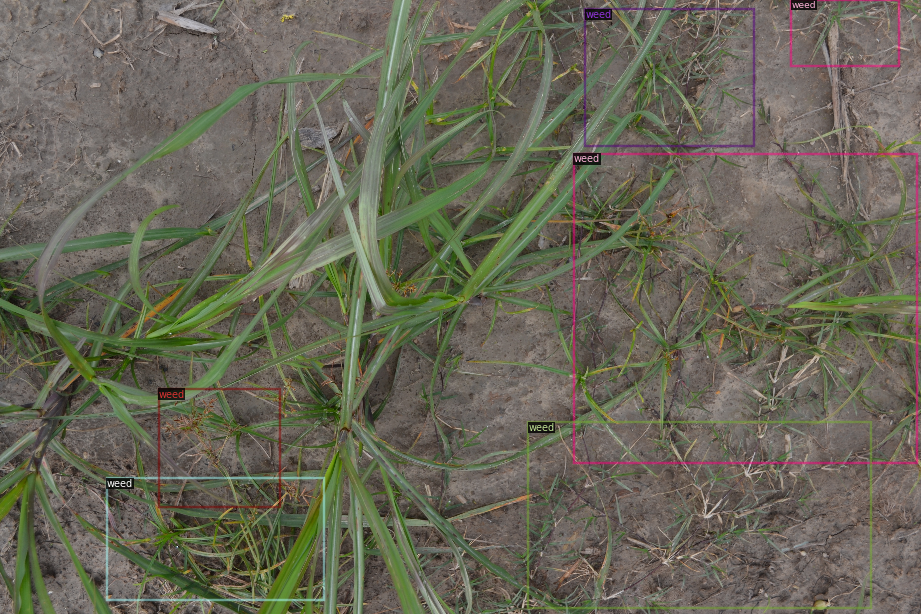

In [13]:
# Verify labels
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=weeds_metadata, scale=0.2)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])


In [ ]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("weeds_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 1000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (weed). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()


[10/30 18:19:26 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

[10/30 18:21:07 d2.engine.train_loop]: Starting training from iteration 0
[10/30 18:21:44 d2.utils.events]:  eta: 0:28:54  iter: 19  total_loss: 1.085  loss_cls: 0.751  loss_box_reg: 0.108  loss_rpn_cls: 0.229  loss_rpn_loc: 0.051  time: 1.7135  data_time: 0.4024  lr: 0.000005  max_mem: 2686M
[10/30 18:22:19 d2.utils.events]:  eta: 0:28:28  iter: 39  total_loss: 1.075  loss_cls: 0.616  loss_box_reg: 0.133  loss_rpn_cls: 0.319  loss_rpn_loc: 0.050  time: 1.7416  data_time: 0.3116  lr: 0.000010  max_mem: 2686M
[10/30 18:22:54 d2.utils.events]:  eta: 0:27:28  iter: 59  total_loss: 0.776  loss_cls: 0.440  loss_box_reg: 0.169  loss_rpn_cls: 0.091  loss_rpn_loc: 0.042  time: 1.7352  data_time: 0.2961  lr: 0.000015  max_mem: 2686M
[10/30 18:23:29 d2.utils.events]:  eta: 0:26:56  iter: 79  total_loss: 0.693  loss_cls: 0.332  loss_box_reg: 0.180  loss_rpn_cls: 0.141  loss_rpn_loc: 0.049  time: 1.7368  data_time: 0.3761  lr: 0.000020  max_mem: 2686M
[10/30 18:24:04 d2.utils.events]:  eta: 0:26:3

In [18]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

<IPython.core.display.Javascript object>

In [30]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

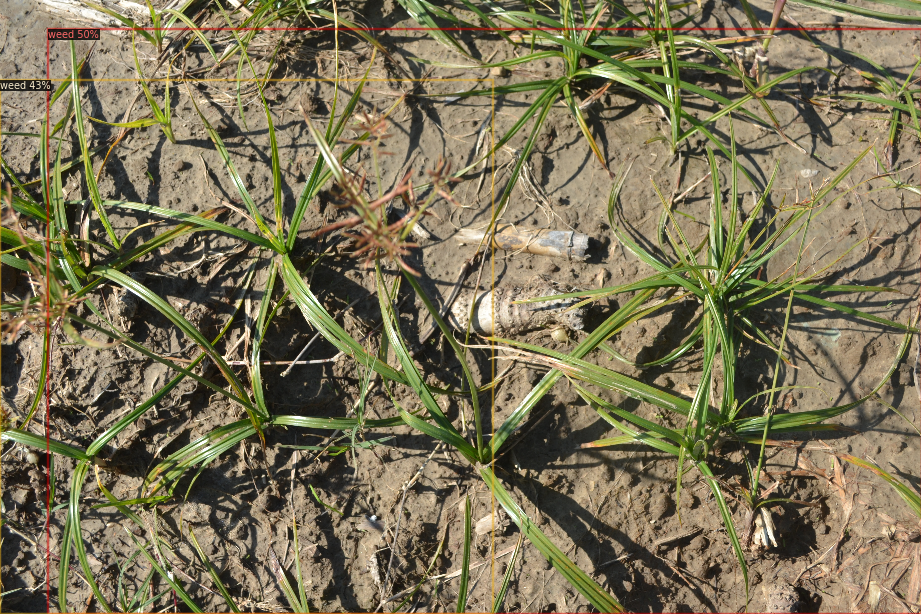

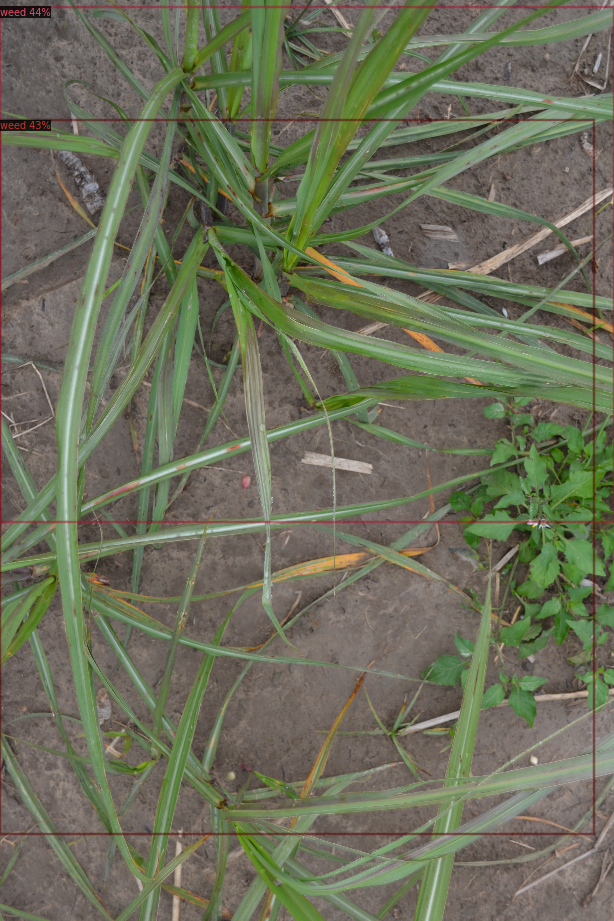

In [28]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_weed_dicts(img_dir, file_lists['val'])
for d in random.sample(dataset_dicts, 2):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=weeds_metadata, 
                   scale=0.2, 
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [29]:
outputs

{'instances': Instances(num_instances=2, image_height=4608, image_width=3072, fields=[pred_boxes: Boxes(tensor([[   0.0000,   39.6275, 3072.0000, 2612.8335],
         [   0.0000,  605.4600, 2971.3403, 4173.0059]], device='cuda:0')), scores: tensor([0.4403, 0.4252], device='cuda:0'), pred_classes: tensor([0, 0], device='cuda:0')])}

In [31]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("weeds_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "weeds_val")
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[10/30 17:50:43 d2.evaluation.coco_evaluation]: 'weeds_val' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[10/30 17:50:43 d2.data.datasets.coco]: Converting annotations of dataset 'weeds_val' to COCO format ...)
[10/30 17:51:26 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[10/30 17:51:26 d2.data.datasets.coco]: Conversion finished, #images: 85, #annotations: 319
[10/30 17:51:26 d2.data.datasets.coco]: Caching COCO format annotations at './output/weeds_val_coco_format.json' ...
[10/30 17:51:53 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    weed    | 319          |
|            |              |
[10/30 17:51:53 d2.data.common]: Serializing 85 elements to byte tensors and concatenating them all ...
[10/30 17:51:53 d2.data.common]: Serialized dataset takes 0.02 MiB
[10/30 17:51:53 d2.data.dataset_mapper]: Augmentations used in training: